In [1]:
'''
Resample stationary time series by using Stationary Bootstrap Method (Boris Radovanov and Aleksandra Marcikić)
and subsequently generate confidence bands.

Deepak Kumar Gouda
6 November, 2018
'''

'\nResample stationary time series by using Stationary Bootstrap Method (Boris Radovanov and Aleksandra Marcikić)\nand subsequently generate confidence bands.\n\nDeepak Kumar Gouda\n6 November, 2018\n'

In [2]:
import numpy as np
from numpy.random import randint, geometric
from math import factorial, sqrt
import matplotlib.pyplot as plt
from pandas import read_csv

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard, EarlyStopping

Using TensorFlow backend.


In [4]:
from time import time
import itertools

In [5]:
# Generate X and Y pairs where dim of X = (1, look_back)
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [6]:
# Arrange blocks of data according to permutation
def arrange_data(data, perm):
    arranged_data = []
    for i in perm:
        arranged_data.append(data[i])
    return arranged_data

In [7]:
def data_resample(data, blockSize, overlap = 0):
    n = len(data) # 100
    numBlocks = (n-overlap)//(blockSize-overlap) # 20
    resampled_data = []
    i = 0
    while (i+blockSize) <= len(data):
        x = data[i: (i+blockSize)]
        indx = randint(0, blockSize, size = blockSize)
        y = [x[j] for j in indx]
        resampled_data.append(y)
        i = i + blockSize - overlap
    return resampled_data

In [8]:
def block_resample(data, blockSize, overlap = 0):
    n = len(data) # 100
    numBlocks = (n-overlap)//(blockSize-overlap) # 20
    I = randint(1, len(data), size=(numBlocks, 1))
    L = geometric(0.0027, size=(numBlocks, 1))
    resampled_data = []
    
    for i in range(numBlocks):
#         print(I[i], I[i]+L[i])
        if I[i]+L[i] < len(data):
            x = data[int(I[i]): int(I[i]+L[i])]
        else:
            x = data[int(I[i]):]
            x1 = data[: int(L[i]-(len(data)-I[i]))]
            x = x.reshape((len(x), 1))
            x1 = x1.reshape((len(x1), 1))
            np.vstack((x, x1))
#         print(x)
        x = np.reshape(x, (len(x), 1))
        resampled_data.append(x)
    print(len(resampled_data))
    return resampled_data

In [9]:
block_resample(data, 200)

NameError: name 'data' is not defined

In [66]:
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)
print(data.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(1259, 2)


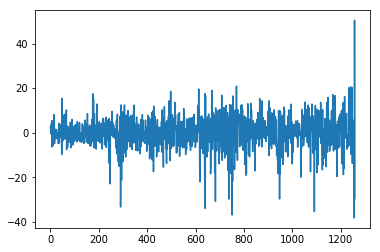

In [67]:
plt.plot(data[:,1] - data[:,0])
plt.show()

In [68]:
data = data[:,1] - data[:,0]
# data = np.reshape(data, (len(data), 1))
data = data.reshape((len(data), 1))
# data = data.reshape((-1, 1))

In [69]:
# Scale between (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.46061351]
 [0.4537273 ]
 [0.42510883]
 [0.44644525]
 [0.47670012]]


In [70]:
split = 0.72
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

906
353


In [71]:
train = data[0:trainSize,:]
test = data[trainSize:len(data),:]
print(train[:5])

[[0.46061351]
 [0.4537273 ]
 [0.42510883]
 [0.44644525]
 [0.47670012]]


In [72]:
# l = block size
blockSize = 300
overlap = 0
numBlocks = (len(train) - overlap)//(blockSize - overlap)
# print(blockSize)

In [73]:
numBlocks

3

In [74]:
randint(1, len(data), size=(len(data), 1))
geometric(0.0027, size=(numBlocks, 1))

array([[590],
       [540],
       [469]])

In [75]:
A = np.array([[[1], [2], [3]], [[4], [5], [6]], [[7], [8], [9]]])
print(A[0].shape)
B = np.reshape(A, (A.shape[0]*A[0].shape[0], A[0].shape[1]))
B

(3, 1)


array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [77]:
# Generate all permutations of the series 0, 1, 2, ... numBlocks
permutations = itertools.permutations(range(numBlocks))
testBand = []
count = 1
suffix = "B"

totalCount = factorial(numBlocks)
for perm in permutations:
    print("Count = %d/%d" % (count, totalCount))
    count += 1
    trainResample = block_resample(train, blockSize)
#     print(len(trainResample))
    suffix = "B"
    trainSet = np.array(arrange_data(trainResample, perm))
#     print(trainSet[0].shape)
#     trainSet = np.reshape(trainSet, (trainSet.shape[0]*trainSet[0].shape[0], trainSet[0].shape[1]))
#     trainSet = np.reshape(trainSet, (trainSet.shape[0]*trainSet[0].shape[0], 1))
#     trainSet = np.reshape(trainSet, (trainSet.shape[0], 1))
#     print(trainSet.shape)
    flattenTrainSet = []
    for i in trainSet:
        for j in i:
            flattenTrainSet.append(j)
            
    trainSet = flattenTrainSet


# test.shape
    trainSet = np.reshape(trainSet, (len(trainSet), 1))

    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)
    print(trainX.shape)
    print(trainY.shape)

#     trainX = np.reshape(trainX, (trainX.shape[0], 3, 1))
#     testX = np.reshape(testX, (testX.shape[0], 3, 1))

    units = 100
    drop = 0.2
    epoch = 10

#     model = load_model("./Models/ResampledBlockBootstrap/"+str(numBlocks)+"_"+str(overlap)+"_"+str(epoch)+".h5")
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='nadam')
#     Tensorboard
#     model.summary()
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#     model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, 
#               callbacks=[EarlyStopping(monitor='loss', patience=2), tensorboard])
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

#     Inverse the scaling
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

#     RMSE score
    trainScore = sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

#     Plot training data
#     trainPredictPlot = np.empty_like(shuffleData)
#     trainPredictPlot[:, :] = np.nan
#     trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict
    
#     Plot test data
#     testPredictPlot = np.empty_like(shuffleData)
#     testPredictPlot[:, :] = np.nan
#     testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict
    
#     Append results to calculate the test band
    testBand.append(testPredict)
#     plt.plot(scaler.inverse_transform(shuffleData)[:,col])
#     plt.plot(trainPredictPlot[:,col], color = 'orange')
#     plt.plot(testPredictPlot[:,col], color = 'green')

Count = 1/6
3
(578, 3, 1)
(578, 1)
Epoch 1/10
578/578 [==============================] - 16s 28ms/step - loss: 0.0102
Epoch 2/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0077
Epoch 3/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0073
Epoch 4/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0074
Epoch 5/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0073
Epoch 6/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0071
Epoch 7/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0070
Epoch 8/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0070
Epoch 9/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0071
Epoch 10/10
578/578 [==============================] - 3s 5ms/step - loss: 0.0070
Train Score: 7.23 RMSE
Test Score: 8.34 RMSE
Count = 2/6
3
(437, 3, 1)
(437, 1)
Epoch 1/10
437/437 [==============================] - 3s 6ms/step - loss

In [78]:
model.save("./Models/StationaryBootstrap/"+str(numBlocks)+"_"+str(epoch)+"_"+suffix+".h5")

Text(0.5,1,'Epoch=10 numBlocks=3 Overlap=0 Train=8.70 Test=9.36')

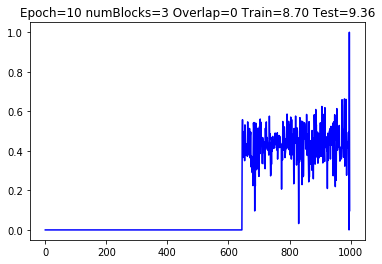

In [79]:
col = 0
testPlot = np.empty_like(trainSet)
testPlot[:, :] = 0
testPlot = np.vstack((testPlot, test))
testplot = scaler.inverse_transform(testPlot)
plt.plot(testPlot[:,col], color = 'blue')
plt.title('Epoch=%d numBlocks=%d Overlap=%d Train=%.2f Test=%.2f' % (epoch, numBlocks, overlap, trainScore, testScore))

In [80]:
testBand = np.array(testBand)
testBand = np.reshape(testBand, (testBand.shape))

In [81]:
testBand.shape

(6, 349, 1)

In [82]:
print(np.mean(testBand[:,0,:], axis = 0))
print(np.std(testBand[:,0,:], axis = 0))

[-0.16840895]
[1.4512836]


In [83]:
z_alpha = 1.96
n = factorial(numBlocks)

confInterval = []

# Calculate the 95% confidence interval for each time step
for i in range(testBand.shape[1]):
    X = testBand[:, i, :]
    xBar = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    l = xBar - 1.96*s/(n**0,.5)
    r = xBar + 1.96*s/(n**0,.5)
    pair = [l, r]
    confInterval.append(pair)

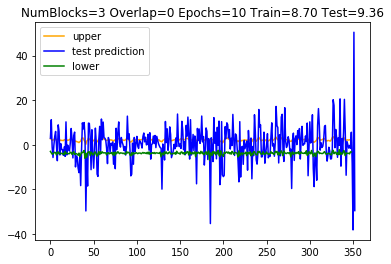

In [85]:
col = 0
offset = len(trainPredict)+(lookBack*2)+2
lower = []
upper = []

# Get upper and lower bounds
for i in range(len(confInterval)):
    lower.append(confInterval[i][0][0])
    upper.append(confInterval[i][1][0])

# XLower = np.array(range(offset+1, offset+1+testBand.shape[1]))
# XUpper = np.array(range(offset+1, offset+1+testBand.shape[1]))
# plt.plot(XLower, lower)
# plt.plot(XUpper, upper)
plt.plot(upper, color='orange', label='upper')
plt.plot(scaler.inverse_transform(test)[:, col], color = 'blue', label='test prediction')
plt.plot(lower, color='green', label='lower')
plt.legend(loc='upper left')
plt.title('NumBlocks=%d Overlap=%d Epochs=%d Train=%.2f Test=%.2f' % (numBlocks, overlap, epoch, trainScore, testScore))
plt.savefig("./Plots/StationaryBootstrap/"+str(numBlocks)+"_"+str(overlap)+"_"+str(epoch)+"_"+suffix+".png")
plt.show()

In [86]:
# Sum of the lengths of the confidence intervals at each time point.
sumIntervals = np.sum(abs(np.array(upper) - np.array(lower)))

In [87]:
sumIntervals

2108.8150548934937

In [88]:
# Length of maximum interval
maxInterval = np.max(np.array(upper) - np.array(lower))

In [89]:
maxInterval

8.107281684875488